# How does AusEFlux represent terrestrial carbon responses to climate extremes?

big droughts, fires, floods

In [21]:
import sys
import folium
import odc.geo
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import xarray as xr
import numpy as np
import contextily as ctx
from odc.geo.geobox import zoom_out
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

In [2]:
# sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
# from dask_utils import start_local_dask

# client = start_local_dask(mem_safety_margin='2Gb')
# client

## Analysis Parameters

Start with 5km resolution datasets to speed up exploration

In [3]:
er_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_ER_2003_2022_5km_quantiles_v1.1.nc'
gpp_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_GPP_2003_2022_5km_quantiles_v1.1.nc'
nee_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_NEE_2003_2022_5km_quantiles_v1.1.nc'
et_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_ET_2003_2022_5km_quantiles_v1.1.nc'

chunks=None#dict(latitude=250, longitude=250, time=1)

#SE AUS
# lat_bounds = slice(355, 590)
# lon_bounds = slice(575,840)

#All of Aus
lat_bounds = slice(0, 680)
lon_bounds = slice(0,840)

## Open data

And clip to lat/lon bounds (examing just SE aus for now)

In [4]:
er = assign_crs(xr.open_dataset(er_path, chunks=chunks)['ER_median'].isel(latitude=lat_bounds, longitude=lon_bounds), crs='EPSG:4326')
gpp = assign_crs(xr.open_dataset(gpp_path, chunks=chunks)['GPP_median'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')
nee = assign_crs(xr.open_dataset(nee_path, chunks=chunks)['NEE_median'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')
et = assign_crs(xr.open_dataset(et_path, chunks=chunks)['ET_median'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')

er =  round_coords(er)
gpp =  round_coords(gpp)
nee =  round_coords(nee)
et =  round_coords(et)


## Define a land cover class to clip too

In [5]:
# trees_path = '/g/data/os22/chad_tmp/NEE_modelling/data/1km/trees_1km_monthly_2002_2022.nc'
# mask_path = '/g/data/os22/chad_tmp/NEE_modelling/data/Tree_1km_monthly_2002_2022.nc'

In [6]:
# mask = assign_crs(xr.open_dataarray(mask_path).isel(time=-1), crs='EPSG:4326')

# grid = zoom_out(mask.odc.geobox, 5)

# mask = mask.odc.reproject(how=grid, resampling='average')
# mask =  round_coords(mask)

# mask = mask.isel(latitude=lat_bounds, longitude=lon_bounds)

# mask = xr.where(mask>15,1,0)
# mask.plot();

### Clip to LC 

In [7]:
# er = er.where(mask)
# gpp = gpp.where(mask)
# nee = nee.where(mask)
# et = et.where(mask)

## Plot extent on interactive map

In [8]:
# m = folium.Map(control_scale = True)

# gpp_trend.odc.add_to(m, robust=True)

# # Zoom map to Australia
# m.fit_bounds(gpp_trend.odc.map_bounds())

# tile = folium.TileLayer(
#         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Satellite',
#         overlay = True,
#         control = True
#        ).add_to(m)

# folium.LayerControl().add_to(m)
# display(m)

## Plot timeseries

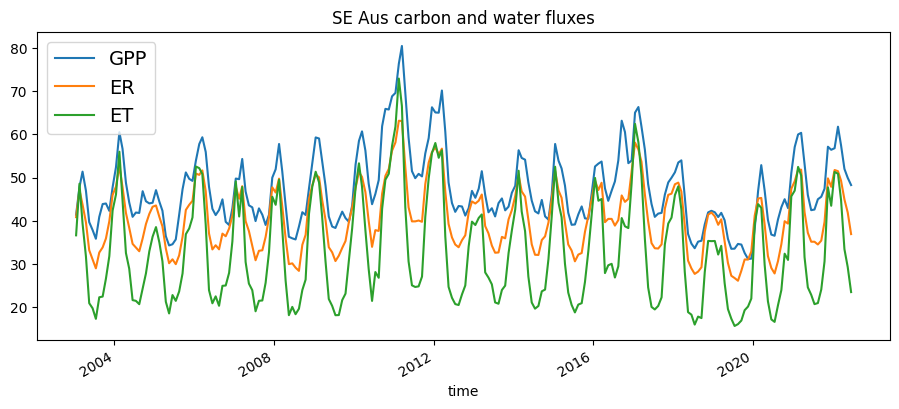

In [9]:
fig,ax = plt.subplots(1,1, figsize=(11,4))
gpp.mean(['latitude','longitude']).compute().plot(ax=ax, label='GPP')
er.mean(['latitude','longitude']).compute().plot(ax=ax, label='ER')
# nee.mean(['latitude','longitude']).plot(ax=ax, label='NEE')
et.mean(['latitude','longitude']).compute().plot(ax=ax, label='ET')

ax.legend(loc='best', fontsize=14)
ax.set_ylabel('', fontsize=14)
ax.set_title('SE Aus carbon and water fluxes');

## Anomalies

In [10]:
er_clim_mean = er.groupby('time.month').mean().compute()
gpp_clim_mean = gpp.groupby('time.month').mean().compute()
nee_clim_mean = nee.groupby('time.month').mean().compute()
et_clim_mean = et.groupby('time.month').mean().compute()

In [11]:
er_anom = (er.groupby('time.month') - er_clim_mean).compute()
gpp_anom = (gpp.groupby('time.month') - gpp_clim_mean).compute()
nee_anom = (nee.groupby('time.month') - nee_clim_mean).compute()
et_anom = (et.groupby('time.month') - et_clim_mean).compute()

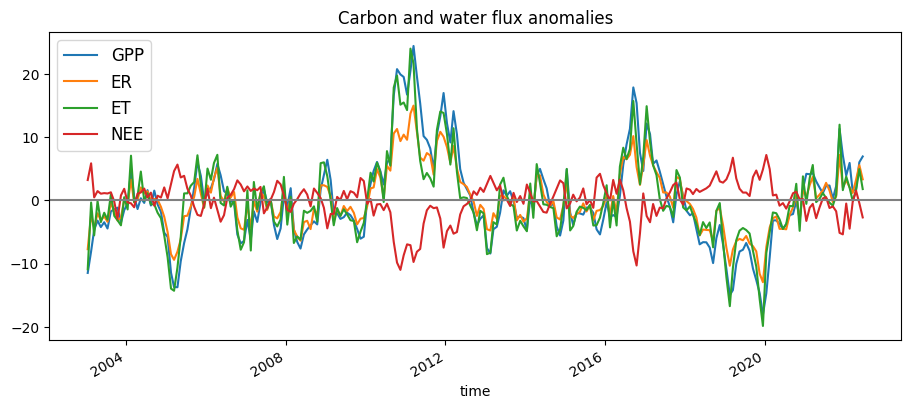

In [12]:
fig,ax = plt.subplots(1,1, figsize=(11,4))
gpp_anom.mean(['latitude','longitude']).plot(ax=ax, label='GPP')
er_anom.mean(['latitude','longitude']).plot(ax=ax, label='ER')
et_anom.mean(['latitude','longitude']).plot(ax=ax, label='ET')
nee_anom.mean(['latitude','longitude']).plot(ax=ax, label='NEE')

ax.legend(loc='best', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.axhline(0, c='grey')
ax.set_title('Carbon and water flux anomalies');

## Water Use Efficiency

In [13]:
wue = gpp/et

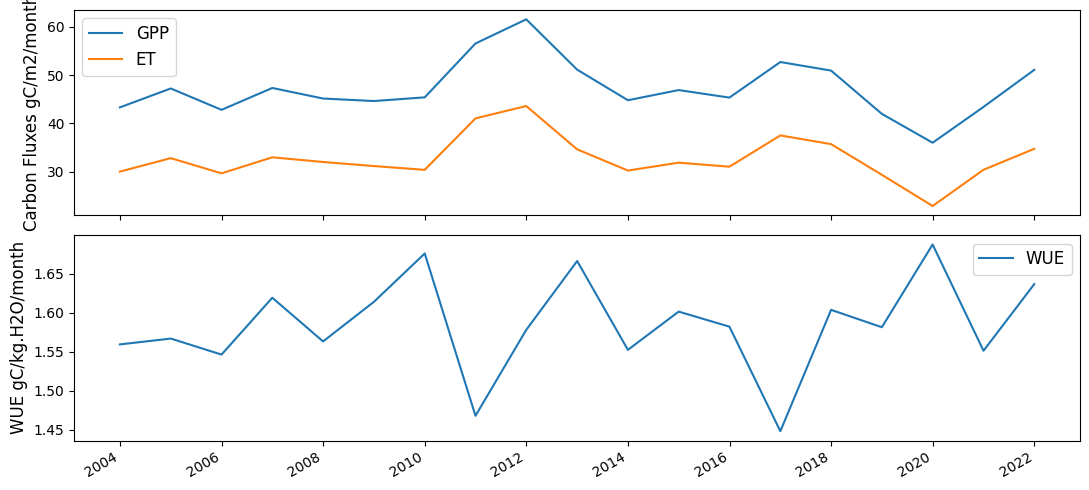

In [14]:
fig,ax = plt.subplots(2,1, figsize=(11,5), sharex=True)
gpp.sel(time=slice('2003', '2021')).resample(time='1Y').mean().mean(['latitude','longitude']).plot(ax=ax[0], label='GPP')
et.sel(time=slice('2003', '2021')).resample(time='1Y').mean().mean(['latitude','longitude']).plot(ax=ax[0], label='ET')
# er.sel(time=slice('2003', '2021')).resample(time='1Y').mean().mean(['latitude','longitude']).plot(ax=ax[0], label='ER')
# (gpp-et).sel(time=slice('2003', '2021')).resample(time='1Y').mean().mean(['latitude','longitude']).plot(ax=ax[0], label='GPP-ET')

wue.sel(time=slice('2003', '2021')).resample(time='1Y').mean().mean(['latitude','longitude']).plot(ax=ax[1], label='WUE')

ax[0].legend(loc='best', fontsize=12)
ax[1].legend(loc='best', fontsize=12)
ax[1].set_ylabel('WUE gC/kg.H2O/month', fontsize=12)
ax[0].set_ylabel('Carbon Fluxes gC/m2/month', fontsize=12)
ax[1].set_xlabel('')
ax[0].set_xlabel('')
ax[0].set_title('')
ax[1].set_title('')
plt.tight_layout();

## Linear Trends

In [15]:
import dask.array as da
from dask.delayed import delayed
from  scipy import stats

def _calc_slope(y):
    """return linear regression statistical variables"""
    mask = np.isfinite(y)
    x = np.arange(len(y))
    return stats.linregress(x[mask], y[mask])

# regression function defition
def regression(y):
    """apply linear regression function along time axis"""
    axis_num = y.get_axis_num('time')
    return da.apply_along_axis(_calc_slope, axis_num, y)

def linregress(ds):

    # fill pixels that are all-NaNs
    allnans = ds.isnull().all('time')
    ds = ds.where(~allnans, other=0)

    # regression analysis
    delayed_objs = delayed(regression)(ds).persist()

    # transforms dask.delayed to dask.array
    results = da.from_delayed(delayed_objs, shape=(5, ds.shape[1:][0], ds.shape[1:][1]), dtype=np.float32)
    results = results.compute()
    results = results.compute() #need this twice haven't figured out why

    # statistical variables definition
    variables = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']

    # coordination definition
    coords = {'latitude': ds.latitude, 'longitude': ds.longitude}

    # output xarray.Dataset definition
    ds_out = xr.Dataset(
        data_vars=dict(slope=(["latitude", "longitude"], results[0]),
                       intercept=(["latitude", "longitude"], results[1]),
                       r_value=(["latitude", "longitude"], results[2]),
                       p_value=(["latitude", "longitude"], results[3]),
                       std_err=(["latitude", "longitude"], results[4]),
                      ),
        coords = coords)

    #remask all-NaN pixel
    return ds_out.where(~allnans)


### Calculate trend in the annual series

In [16]:
warnings.filterwarnings("ignore")
wue_trend = linregress(wue.sel(time=slice('2003', '2021')).resample(time='1Y').mean())
gpp_trend = linregress(gpp.sel(time=slice('2003', '2021')).resample(time='1Y').mean())
et_trend = linregress(et.sel(time=slice('2003', '2021')).resample(time='1Y').mean())
er_trend = linregress(er.sel(time=slice('2003', '2021')).resample(time='1Y').mean())
nee_trend = linregress(nee.sel(time=slice('2003', '2021')).resample(time='1Y').mean())

### Plot

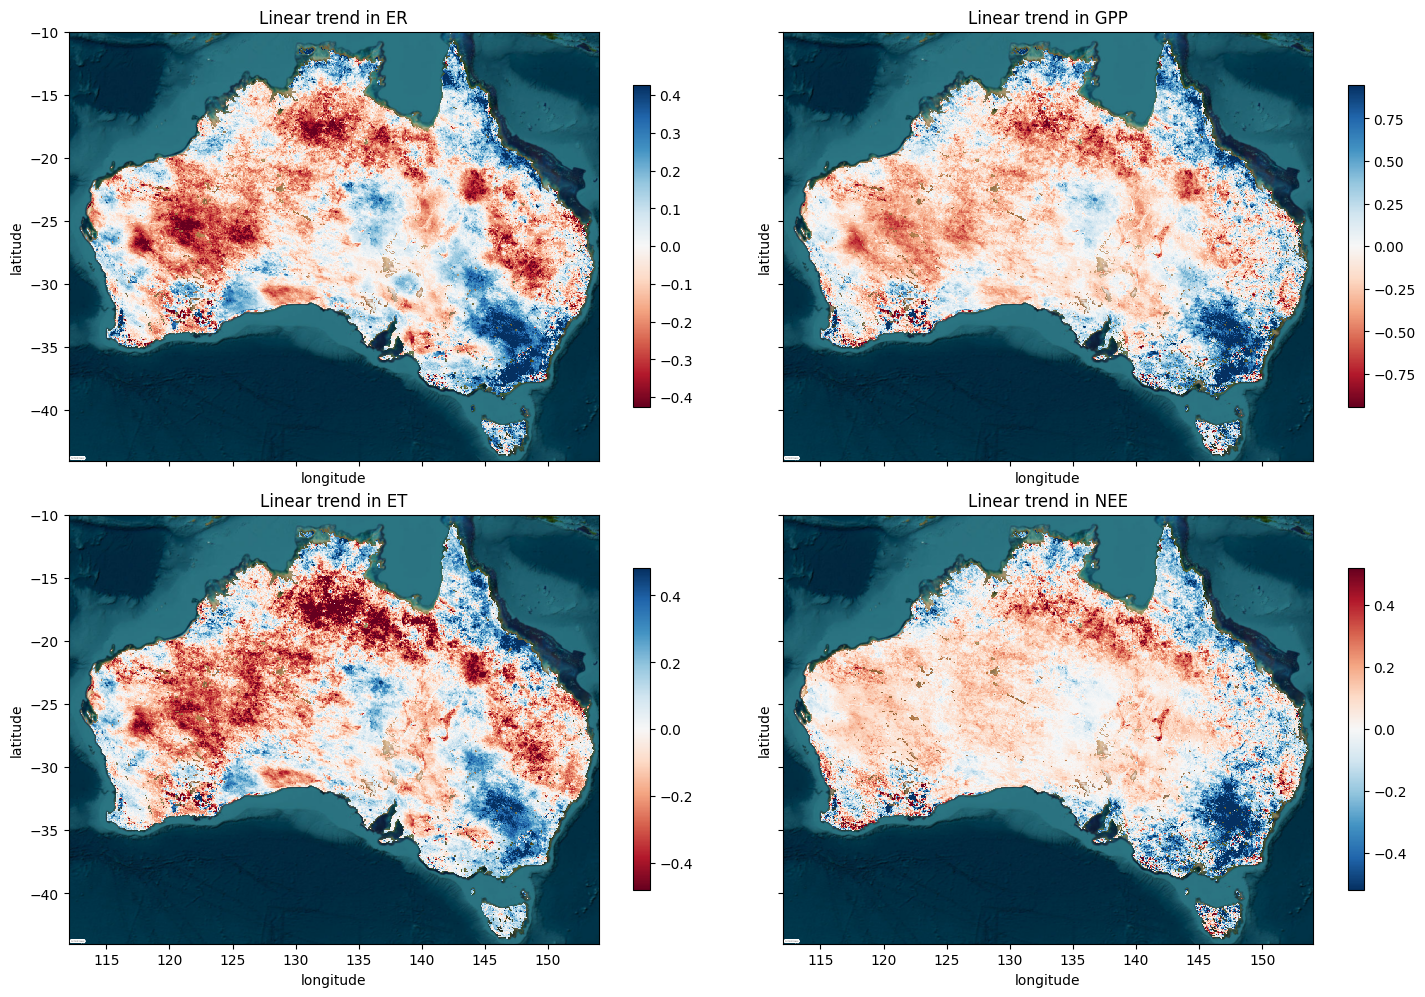

In [17]:
fig,ax = plt.subplots(2,2, figsize=(15,10), sharex=True, sharey=True)

im = er_trend.slope.plot(cmap='RdBu', robust=True, ax=ax[0,0], add_colorbar=False)
cbar = plt.colorbar(im, ax=ax[0,0], shrink=0.75)
ax[0,0].set_title('Linear trend in ER')
ctx.add_basemap(ax[0,0], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)

im = gpp_trend.slope.plot(cmap='RdBu', robust=True, ax=ax[0,1], add_colorbar=False)
cbar = plt.colorbar(im, ax=ax[0,1], shrink=0.75)
ax[0,1].set_title('Linear trend in GPP')
ctx.add_basemap(ax[0,1], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)

im = et_trend.slope.plot(cmap='RdBu', robust=True, ax=ax[1,0], add_colorbar=False)
cbar = plt.colorbar(im, ax=ax[1,0], shrink=0.75)
ax[1,0].set_title('Linear trend in ET')
ctx.add_basemap(ax[1,0], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)

im = nee_trend.slope.plot(cmap='RdBu_r', robust=True, ax=ax[1,1], add_colorbar=False)
cbar = plt.colorbar(im, ax=ax[1,1], shrink=0.75)
ax[1,1].set_title('Linear trend in NEE')
ctx.add_basemap(ax[1,1], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)
plt.tight_layout();
plt.savefig('/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/linear_trends.png', bbox_inches='tight')

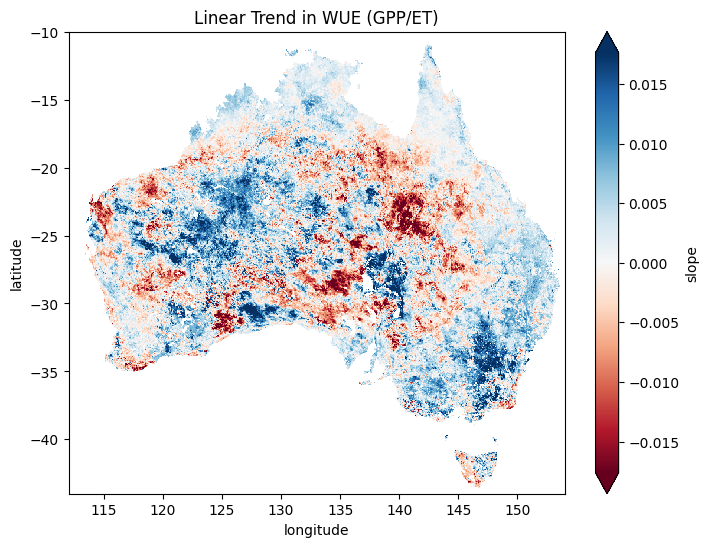

In [18]:
wue_trend.slope.plot(cmap='RdBu', robust=True, size=6)
plt.title('Linear Trend in WUE (GPP/ET)');

## Per bioclimatic region

In [19]:
bio = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.nc'), crs='EPSG:4326')
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [22]:
trends_var = [et_trend, er_trend, nee_trend, gpp_trend, wue_trend]
names = ['ET', 'ER', 'NEE', 'GPP', 'WUE']

outer = []
for index, row in gdf.iterrows():    
    mask = xr_rasterize(gdf.iloc[[index]], gpp.isel(time=1))
    mask = round_coords(mask)

    inner = []
    for v,n in zip(trends_var, names):
        var_region = v.where(mask).compute()
        df_var_region = var_region.slope.drop('spatial_ref').to_dataframe().reset_index(drop=True).rename({'slope':n+'_'+row['region_name']},axis=1)
        inner.append(df_var_region)
    outer.append(inner)


### Plot trend distribution per region

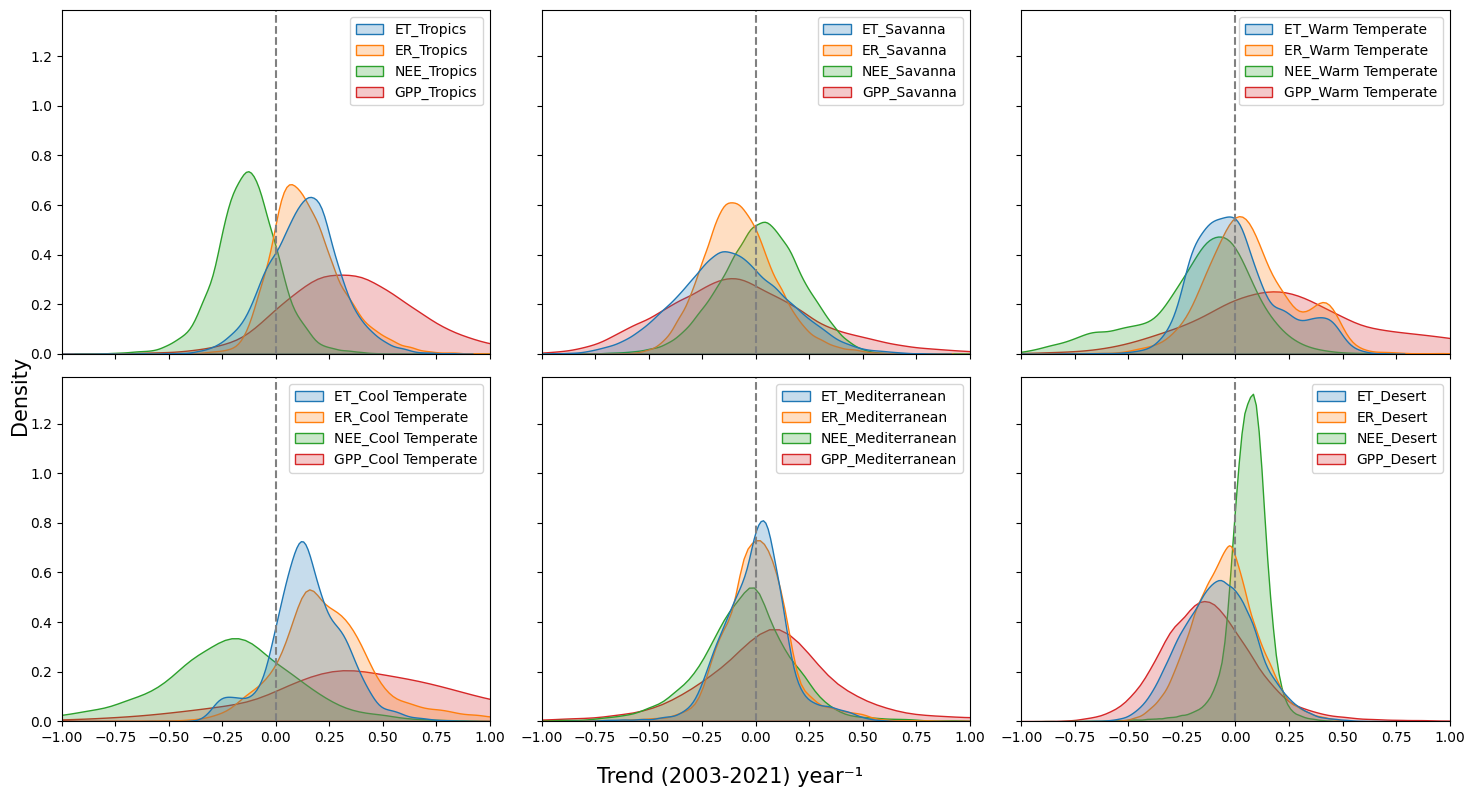

In [27]:
fig,ax = plt.subplots(2,3, figsize=(15,8), sharex=True, sharey=True)
for a,i,n in zip(ax.reshape(-1), range(0,6), list(gdf.region_name.values)): 
    dff = pd.concat(outer[i])
    sb.kdeplot(dff.drop('WUE_'+n, axis=1), fill=True, ax=a)
    a.axvline(0, c='grey', linestyle='--')
    a.set_xlim(-1.0, 1.0)
    a.set_ylabel('')
fig.supylabel('Density', fontsize=15)
fig.supxlabel('Trend (2003-2021) year⁻¹', fontsize=15)
plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/trend_dist_bioregion.png", bbox_inches='tight')